In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #For ploting
import torch    #Pytorch
import os

In [2]:
# Look into the data directory
# first, generate figure.
data_dir = r'M:\cs230_project\virufy_small_dataset_12s_classification'
#print(os.listdir(data_dir))

#Training data directory
train_dir = (data_dir + '/train')
print('Classes:')
print(os.listdir(train_dir))

#Test data directory
test_dir = (data_dir + '/test')

Classes:
['detectable', 'nondetectable']


In [3]:
# create the datasets

In [4]:
import torchvision.transforms as tt #To apply transformations to the dataset, augmenting it and transforming it to a tensor.
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder #Load dataset

In [5]:
#Transformations aplied to test DS.
train_tf = tt.Compose([         
    tt.ColorJitter(brightness=0),
    tt.Resize(size=(150,150)),
    tt.RandomRotation(0),
    tt.ToTensor(),            
])

#Transformations aplied to test DS.
test_tf= tt.Compose([   
    tt.Resize(size=(150,150)),
    tt.ToTensor(),
])

In [6]:
train_ds = ImageFolder(train_dir,train_tf)
test_ds = ImageFolder(test_dir,test_tf)

len(train_ds), len(test_ds)

(3517, 878)

In [7]:
img,label=train_ds[0]
img.shape

torch.Size([3, 150, 150])

In [8]:
def ds_info(dataset):
    dataset_size=len(dataset)
    classes = dataset.classes
    num_classes = len(classes)
    
    #Initialize list
    count = []     
    for x in range(num_classes):
        count.append(0)
        
    #Count every label
    for x in range(dataset_size):
        count[dataset[x][1]]+=1
        
    print('Size of the dataset:' + str(dataset_size))
    print('Number of classes:' + str(num_classes))    
    print('Samples for every class:')
    
    #Print the count
    for x in range(num_classes):
        print(classes[x] + " : " + str(count[x]))
    

In [9]:
print('Training dataset information:')
ds_info(train_ds)

Training dataset information:


KeyboardInterrupt: 

In [10]:
print('Test dataset information:')
ds_info(test_ds)


Test dataset information:


KeyboardInterrupt: 

In [55]:
batch_size = 254

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=3,
    shuffle=True,
    pin_memory=True
)

test_dl = DataLoader(
    test_ds,
    batch_size=batch_size,
    num_workers=3,
    shuffle=False,
    pin_memory=True
)

In [56]:
from torchvision.utils import make_grid

In [57]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

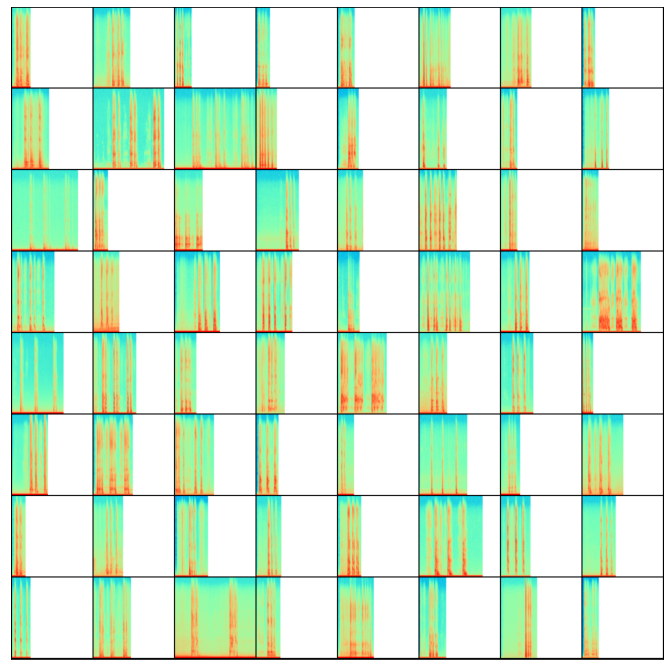

In [58]:
%matplotlib inline
show_batch(train_dl)

In [59]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [60]:
device = get_default_device() #Getting the device
device

train_dl = DeviceDataLoader(train_dl, device) #Transfering train data to GPU
test_dl = DeviceDataLoader(test_dl, device)   #Transfering test data to GPU

In [61]:
# create network

In [62]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [63]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [64]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            (epoch+1), result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [65]:
def conv_block(in_channels, out_channels, pool=False,p_size=2):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(p_size))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 32)                             #32x150x150
        self.conv2 = conv_block(32, 64, pool=True,p_size=4)                  #64x37x37
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        
        self.conv3 = conv_block(64, 128, pool=True,p_size=4)                 #128x9x9
        self.conv4 = conv_block(128, 256, pool=True,p_size=4)                #256x2x2
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2),                     #256x1x1
                                        nn.Flatten(), 
                                        nn.Linear(256, num_classes))
        
    def forward(self, xb):
        
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        
        out = self.classifier(out)
        
        return out

In [66]:
from tqdm.notebook import tqdm

In [67]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [68]:
def plot_scores(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [69]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [70]:
def show_sample(img, target):
    plt.imshow(img.permute(1, 2, 0))
    print('Labels:', target)
    
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    show_sample(img,test_ds.classes[preds[0].item()])

In [50]:
#ResNet9

In [51]:
model = to_device(ResNet9(3,2), device) # two classes 0 and 1
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [52]:
history = [evaluate(model, test_dl)]
history

[{'val_loss': 0.6945499181747437, 'val_acc': 0.5}]

In [53]:
epochs = 20
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [54]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00008, train_loss: 1.2160, val_loss: 0.7040, val_acc: 0.5000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00024, train_loss: 0.8583, val_loss: 0.7512, val_acc: 0.5000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00049, train_loss: 0.7459, val_loss: 0.8359, val_acc: 0.5000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00074, train_loss: 0.7433, val_loss: 0.9411, val_acc: 0.5000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00093, train_loss: 0.6765, val_loss: 0.9475, val_acc: 0.5000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00100, train_loss: 0.6438, val_loss: 0.9356, val_acc: 0.5000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00099, train_loss: 0.6197, val_loss: 0.9847, val_acc: 0.5000


  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

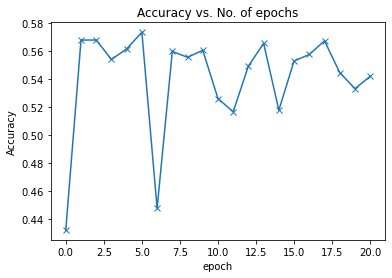

In [32]:
plot_scores(history)

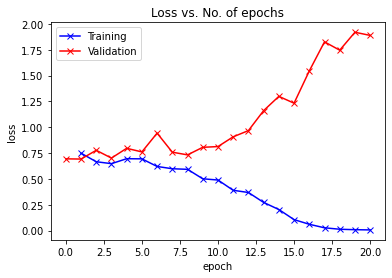

In [33]:
plot_losses(history)

In [71]:
class Resnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [72]:
model = to_device(Resnet18(), device)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to D:\Users\xflu/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Resnet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [73]:
history = [evaluate(model, test_dl)]
history

[{'val_loss': 0.6900178790092468, 'val_acc': 0.5275421142578125}]

In [74]:
epochs = 20
epochs2 = 20
max_lr2 = 0.00005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [75]:
model.freeze()

In [76]:
%%time
history += fit_one_cycle(epochs2, max_lr2, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00000, train_loss: 0.6963, val_loss: 0.6923, val_acc: 0.4906


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00001, train_loss: 0.6879, val_loss: 0.7002, val_acc: 0.4706


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00003, train_loss: 0.6738, val_loss: 0.6972, val_acc: 0.5005


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00004, train_loss: 0.6521, val_loss: 0.7059, val_acc: 0.4906


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00005, train_loss: 0.6152, val_loss: 0.7009, val_acc: 0.5046


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00005, train_loss: 0.5505, val_loss: 0.6949, val_acc: 0.5435


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00005, train_loss: 0.4656, val_loss: 0.7123, val_acc: 0.5238


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00005, train_loss: 0.3935, val_loss: 0.7157, val_acc: 0.5257


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00004, train_loss: 0.3499, val_loss: 0.7248, val_acc: 0.5223


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00004, train_loss: 0.3325, val_loss: 0.7366, val_acc: 0.5050


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00004, train_loss: 0.3242, val_loss: 0.7364, val_acc: 0.5132


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00003, train_loss: 0.3210, val_loss: 0.7299, val_acc: 0.5161


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00003, train_loss: 0.3192, val_loss: 0.7398, val_acc: 0.5119


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00002, train_loss: 0.3182, val_loss: 0.7425, val_acc: 0.5056


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00001, train_loss: 0.3176, val_loss: 0.7425, val_acc: 0.5048


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00001, train_loss: 0.3174, val_loss: 0.7434, val_acc: 0.5048


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00001, train_loss: 0.3175, val_loss: 0.7438, val_acc: 0.5077


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00000, train_loss: 0.3172, val_loss: 0.7433, val_acc: 0.5077


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00000, train_loss: 0.3172, val_loss: 0.7441, val_acc: 0.5068


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00000, train_loss: 0.3171, val_loss: 0.7444, val_acc: 0.5077
Wall time: 6min 38s


In [79]:
model.unfreeze()

In [80]:
%%time
history += fit_one_cycle(epochs2, max_lr2, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00000, train_loss: 0.3171, val_loss: 0.7436, val_acc: 0.5089


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00001, train_loss: 0.3166, val_loss: 0.7442, val_acc: 0.5244


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00003, train_loss: 0.3158, val_loss: 0.7520, val_acc: 0.5042


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00004, train_loss: 0.3152, val_loss: 0.7609, val_acc: 0.4926


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00005, train_loss: 0.3178, val_loss: 0.7659, val_acc: 0.4912


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00005, train_loss: 0.3233, val_loss: 0.7765, val_acc: 0.4968


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00005, train_loss: 0.3256, val_loss: 0.7625, val_acc: 0.5101


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00005, train_loss: 0.3226, val_loss: 0.7464, val_acc: 0.5246


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00004, train_loss: 0.3192, val_loss: 0.7537, val_acc: 0.5104


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00004, train_loss: 0.3176, val_loss: 0.7745, val_acc: 0.4987


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00004, train_loss: 0.3157, val_loss: 0.7628, val_acc: 0.5083


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00003, train_loss: 0.3144, val_loss: 0.7718, val_acc: 0.4936


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00003, train_loss: 0.3141, val_loss: 0.7690, val_acc: 0.4988


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00002, train_loss: 0.3138, val_loss: 0.7741, val_acc: 0.4978


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00001, train_loss: 0.3137, val_loss: 0.7766, val_acc: 0.4886


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00001, train_loss: 0.3137, val_loss: 0.7766, val_acc: 0.4847


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00001, train_loss: 0.3137, val_loss: 0.7762, val_acc: 0.4833


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00000, train_loss: 0.3137, val_loss: 0.7759, val_acc: 0.4873


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00000, train_loss: 0.3137, val_loss: 0.7767, val_acc: 0.4823


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00000, train_loss: 0.3137, val_loss: 0.7774, val_acc: 0.4804
Wall time: 6min 36s


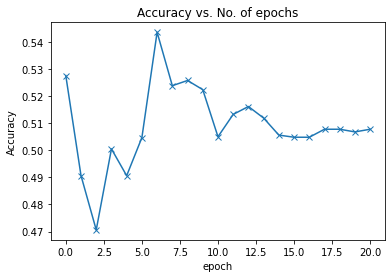

In [77]:
plot_scores(history)

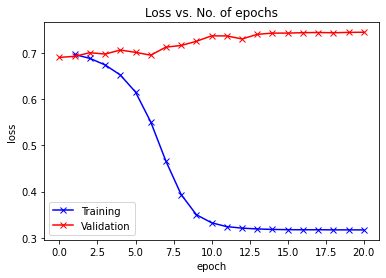

In [78]:
plot_losses(history)

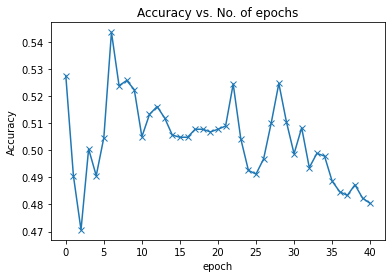

In [81]:
plot_scores(history)

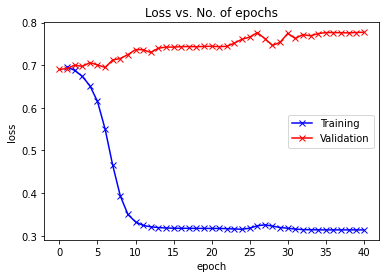

In [82]:
plot_losses(history)